# Logistic Regression with tf-idf embeddings

In [1]:
! pip install swifter pymorphy3 eli5

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Colab_Notebooks/News_Analytics_Project/logreg')

In [4]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import swifter
import eli5
import os
import ast
import pickle
from numba import jit, cuda
from eli5.sklearn import PermutationImportance
from wordcloud import WordCloud
from collections import Counter, defaultdict
from stopwords import mystopwords
import text_helper
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [5]:
data_path = '/content/gdrive/MyDrive/Colab_Notebooks/News_Analytics_Project/data'

In [6]:
df = pd.read_csv(os.path.join(data_path,'news_final_balanced.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42210 entries, 0 to 42209
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               42210 non-null  int64  
 1   url              42210 non-null  object 
 2   title            42210 non-null  object 
 3   content          42210 non-null  object 
 4   datetime         42210 non-null  object 
 5   views            42210 non-null  int64  
 6   tags             42210 non-null  object 
 7   topic            42210 non-null  object 
 8   year             42210 non-null  int64  
 9   month            42210 non-null  object 
 10  weekday          42210 non-null  object 
 11  len_title        42210 non-null  int64  
 12  len_content      42210 non-null  int64  
 13  log_len_title    42210 non-null  float64
 14  log_len_content  42210 non-null  float64
dtypes: float64(2), int64(5), object(8)
memory usage: 4.8+ MB


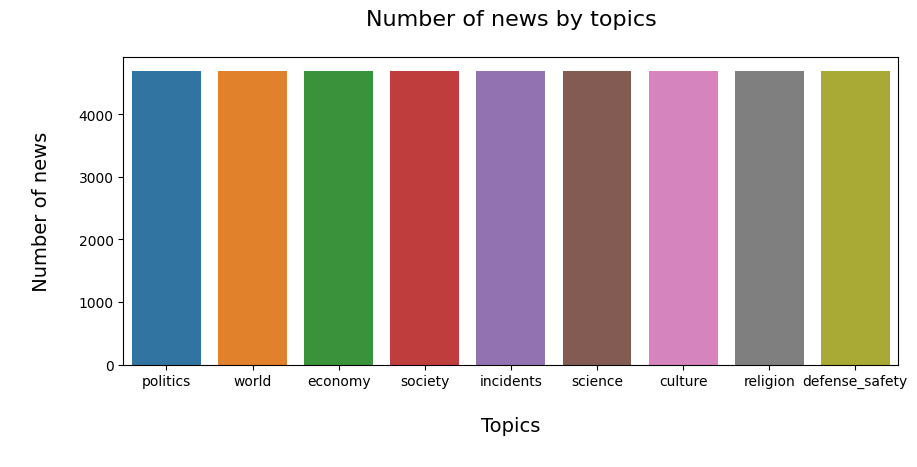

In [7]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10, 4))
sns.countplot(x=df["topic"], palette="tab10", ax=ax)
plt.ylabel("\n Number of news \n", fontsize=14)
plt.xlabel("\nTopics\n", fontsize=14)
plt.title("Number of news by topics\n", fontsize=16)
plt.show();

We have balanced classes. We did full EDA on the previous stage. Now we delete extra columns and get to build classifier models.

In [8]:
columns_to_drop = ['url','datetime','views','year','month','weekday', 'tags',
                   'len_title','len_content', 'log_len_title', 'log_len_content']
df.drop(columns=columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42210 entries, 0 to 42209
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       42210 non-null  int64 
 1   title    42210 non-null  object
 2   content  42210 non-null  object
 3   topic    42210 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


We will use both title and content columns for features. (I experiment with only titles and the results were worse: 0.80 vs 0.88).
Our targets are topic column.

## Split data

We set 80% of the data for training,  20% - for test.

In [9]:
train_data, test_data  = train_test_split(df, train_size=0.8, random_state=42)

In [10]:
train_data.to_csv(os.path.join(data_path,'train_data.csv'), index=False)
test_data.to_csv(os.path.join(data_path,'test_data.csv'), index=False)

In [11]:
data = {
    'train': [f'{train_data.shape[0]} ({len(train_data) / len(df) * 100:.0f}%)'],
    'test': [f'{test_data.shape[0]} ({len(test_data) / len(df) * 100:.0f}%)']
}

df_percentages = pd.DataFrame(data)
df_percentages

train        test
0  33768 (80%)  8442 (20%)

## Text preprocessing

NB: Text preprocessing with lemmatization takes a log time, an hour and 17 mins on CPU, for train and test datasets. We use below preprocessed saved data.

The text normalization we do for logistic regression classifier:

- Delete text data irrelevant for determing the topic:
the source of information in each document,
its authors,
links,
stopwords (function words and words common and specific for news texts),
punctuation marks (though keeping hyphens inside the words),
- Convert to lower case and delete multiple spaces
- Substitute 'ё' for 'е'
- Substitute all numbers for '1' (in some topics numbers may prevail, e.g. economics)
- Lemmatize the text.

In [ ]:
%%time
preprocessed_train = text_helper.preprocess_text(train_data, stopwords=mystopwords, delete_stopwords=True, make_lemmatization=True)
preprocessed_test = text_helper.preprocess_text(test_data, stopwords=mystopwords, delete_stopwords=True, make_lemmatization=True)

Save the results because lemmatization takes a long time

In [ ]:
preprocessed_train.to_csv(os.path.join(data_path,'train_preprocess.csv'), index=False)
preprocessed_test.to_csv(os.path.join(data_path,'test_preprocess.csv'), index=False)

In [12]:
preprocessed_train = pd.read_csv(os.path.join(data_path,'train_preprocess.csv'))
preprocessed_test = pd.read_csv(os.path.join(data_path,'test_preprocess.csv'))

For the purpose of understanding the text data we look at the word cloud for every topic generated from news texts.

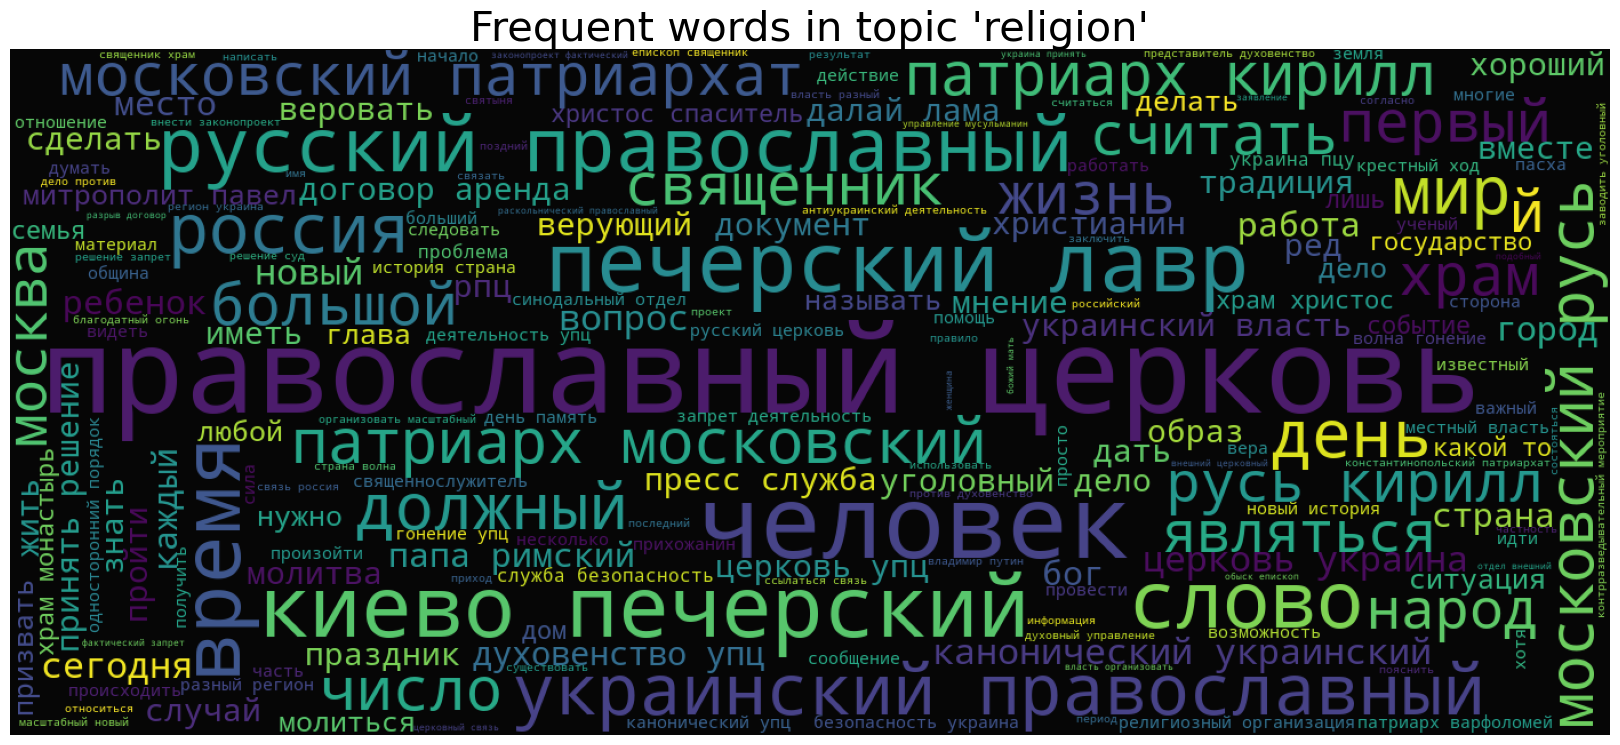

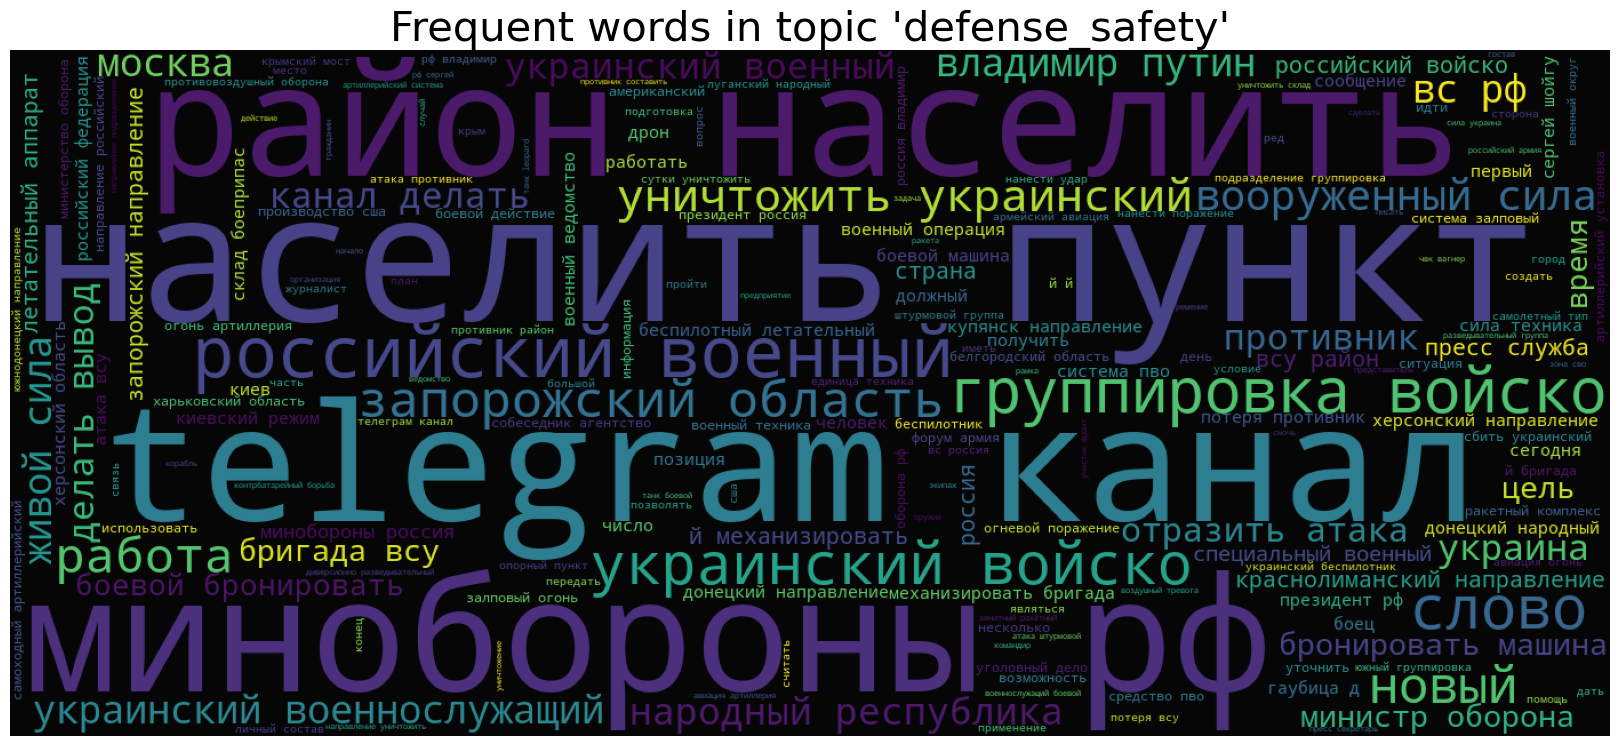

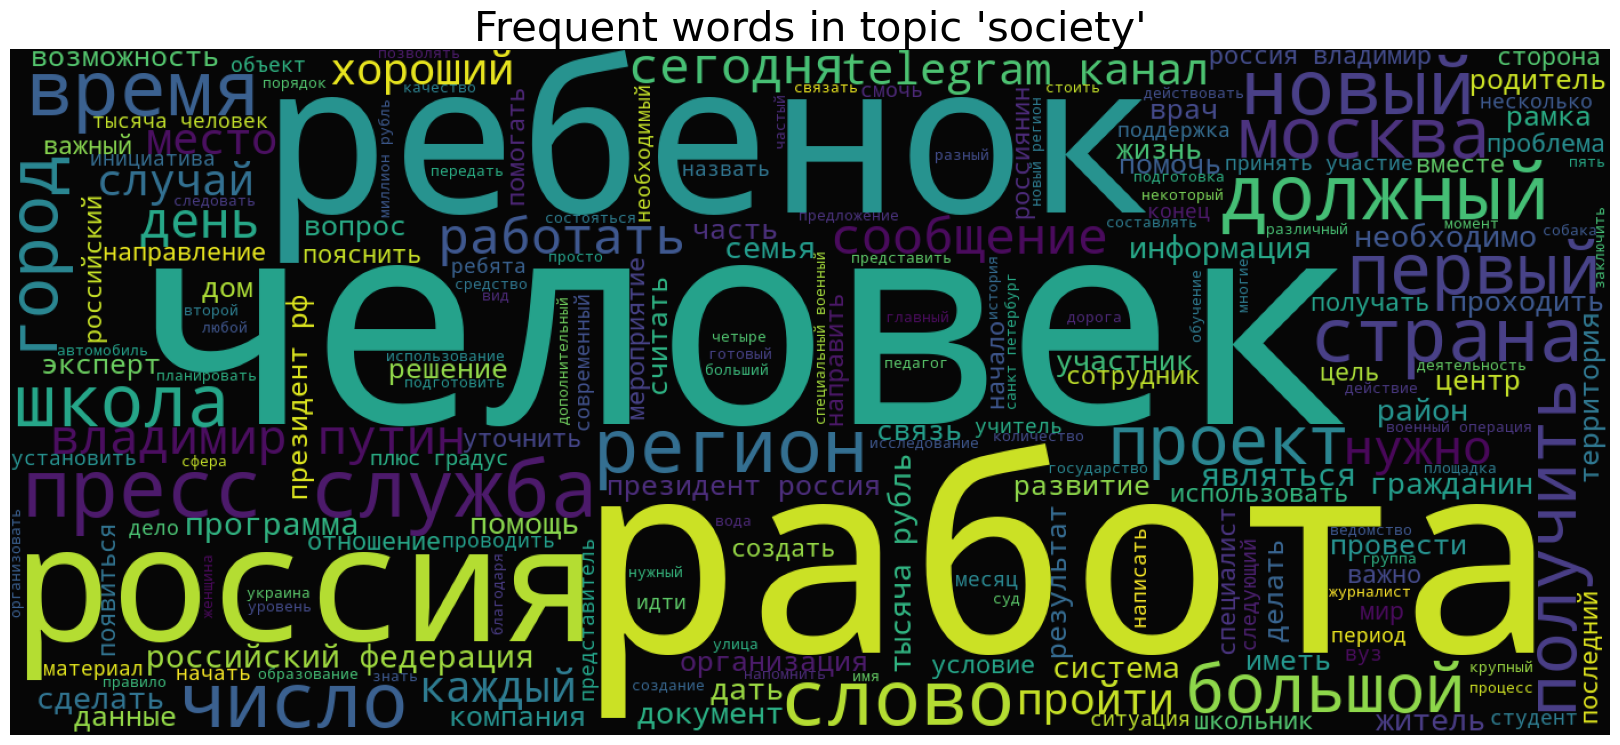

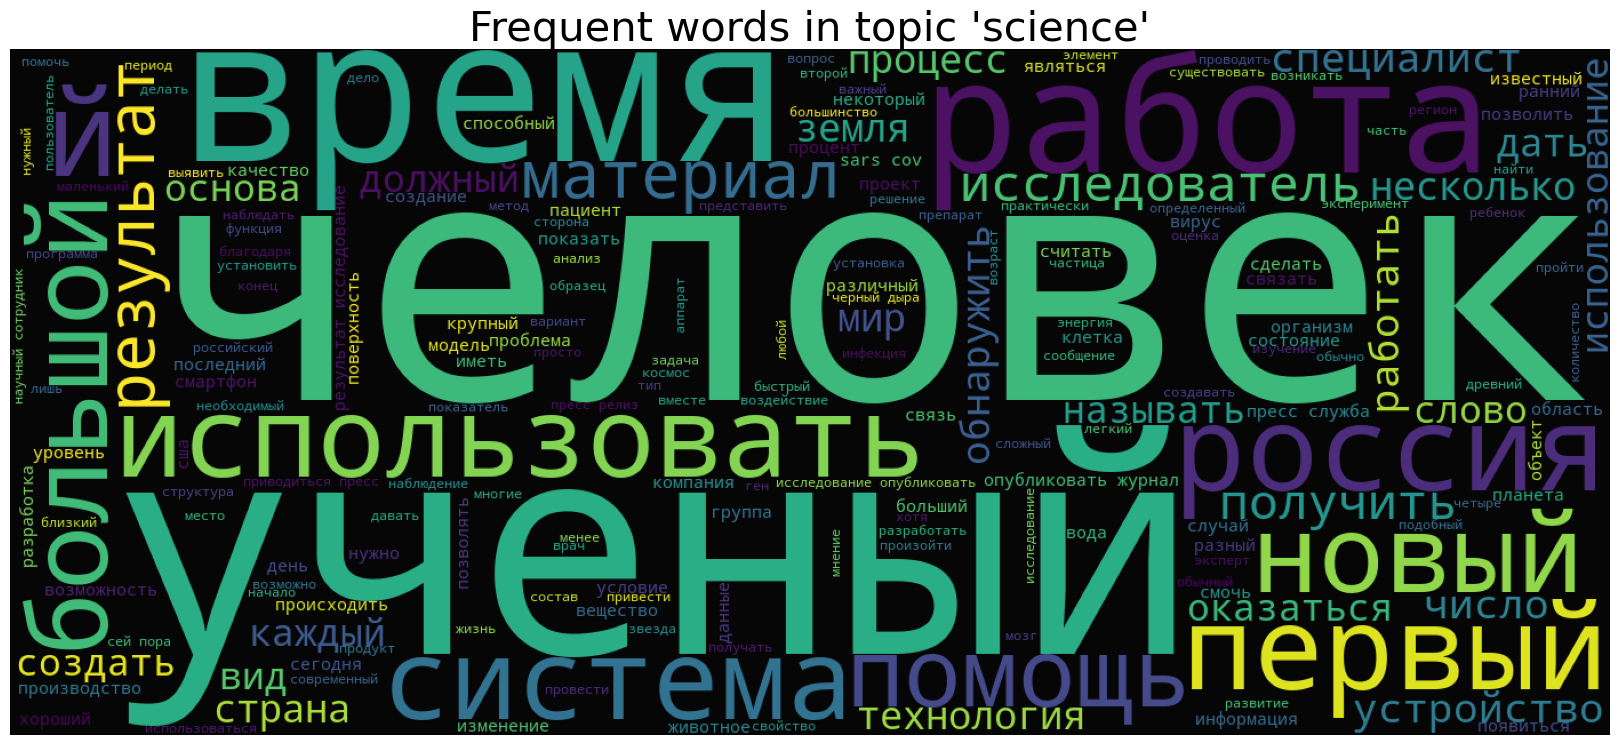

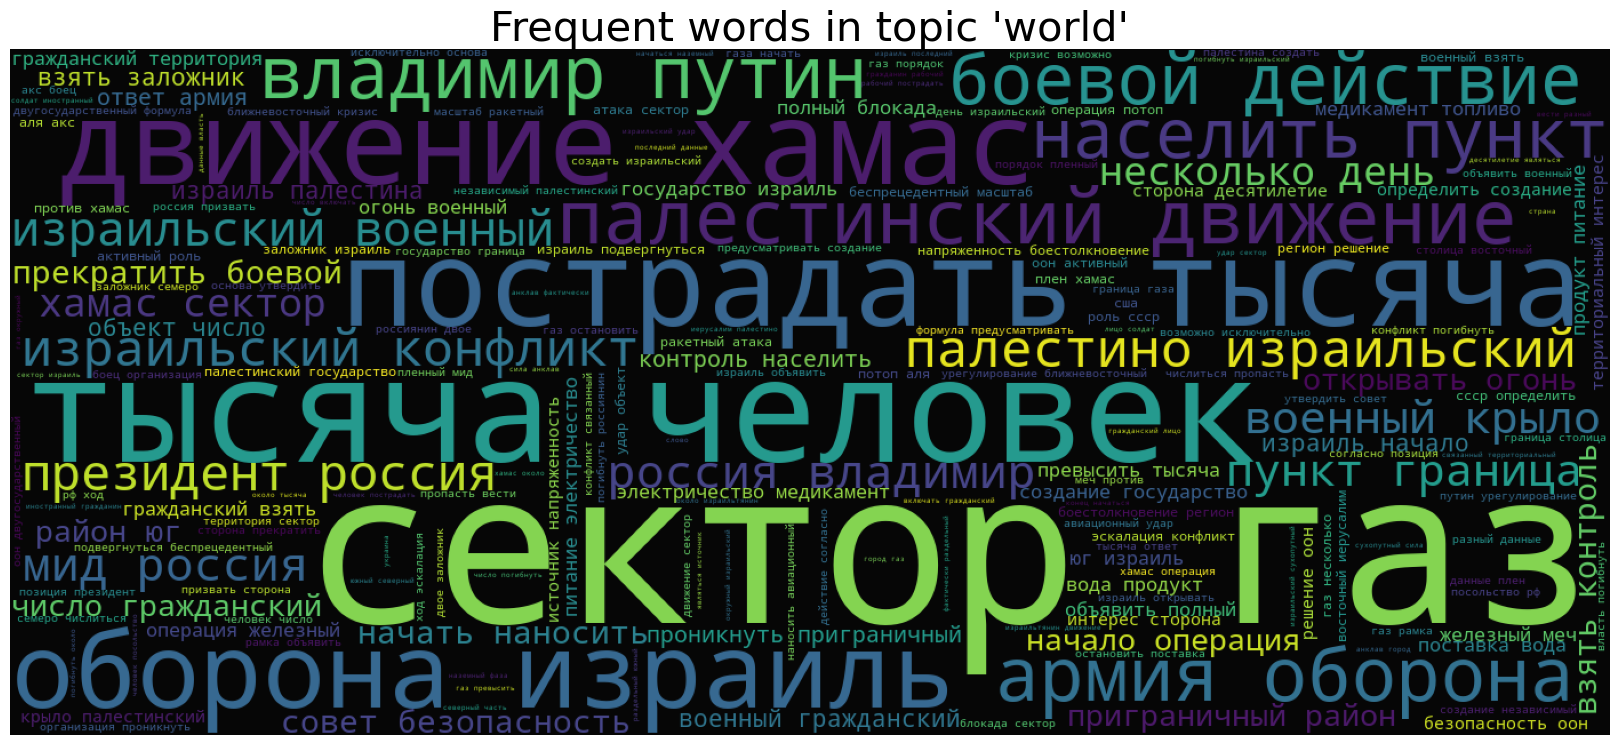

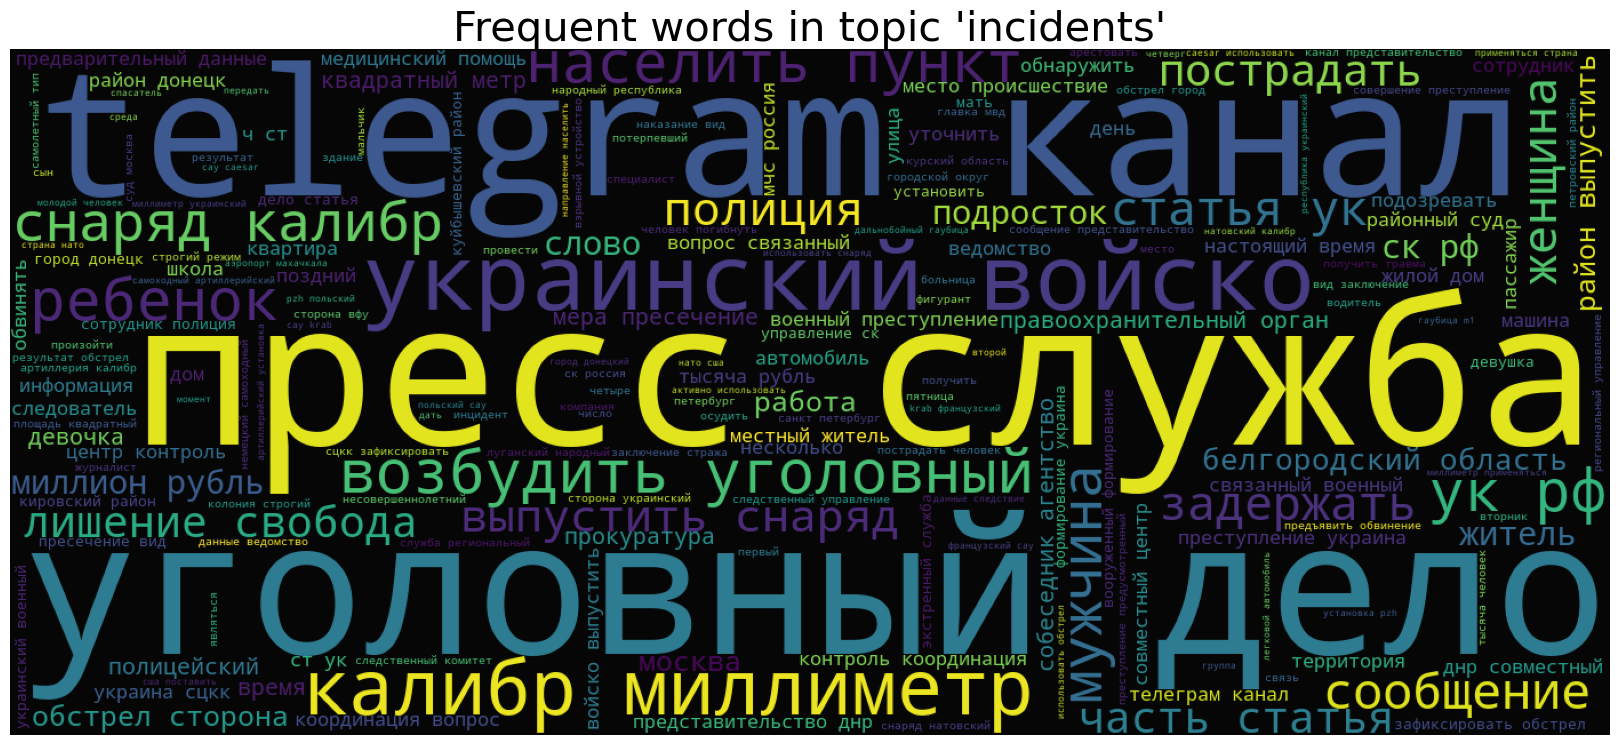

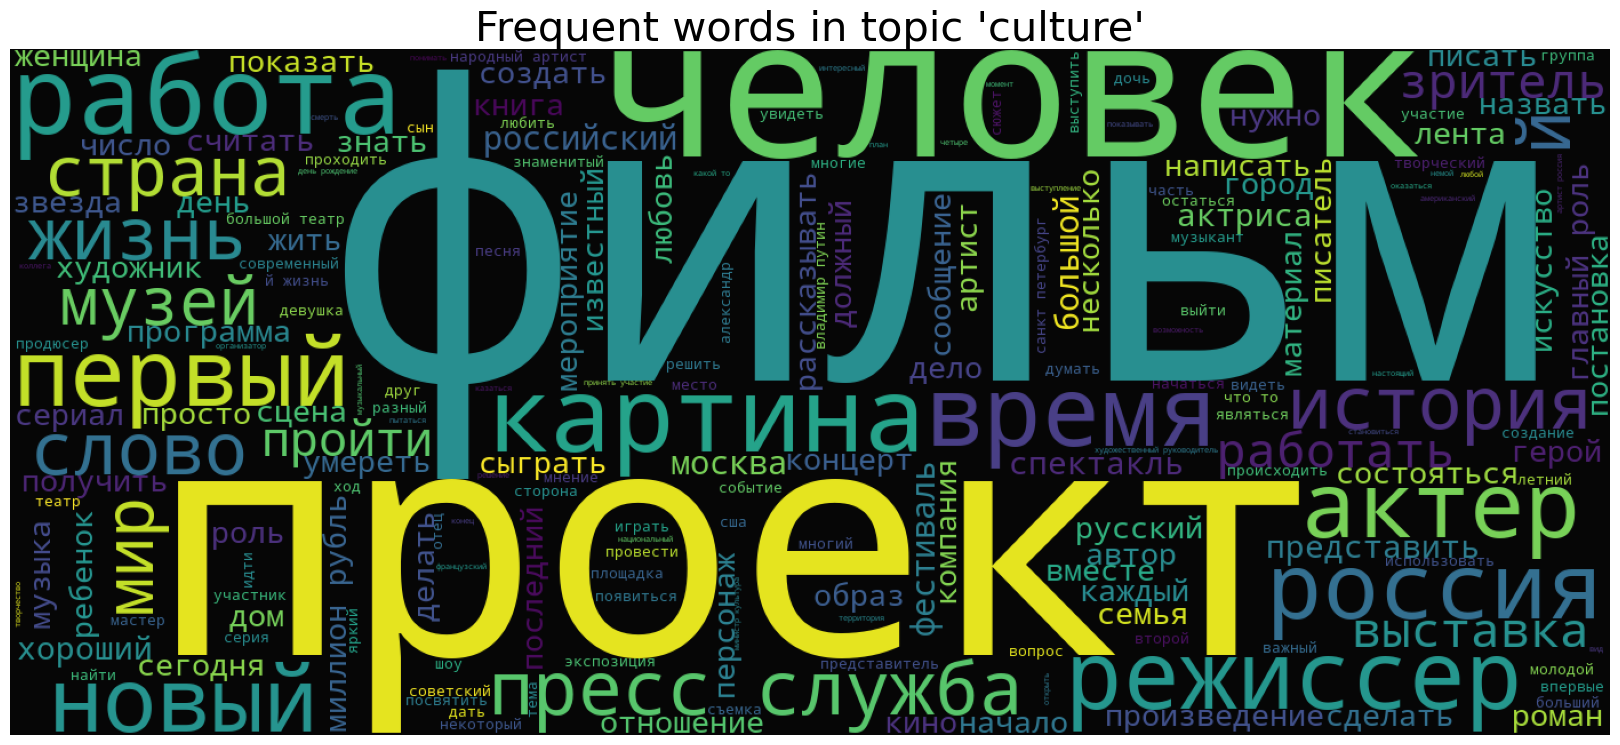

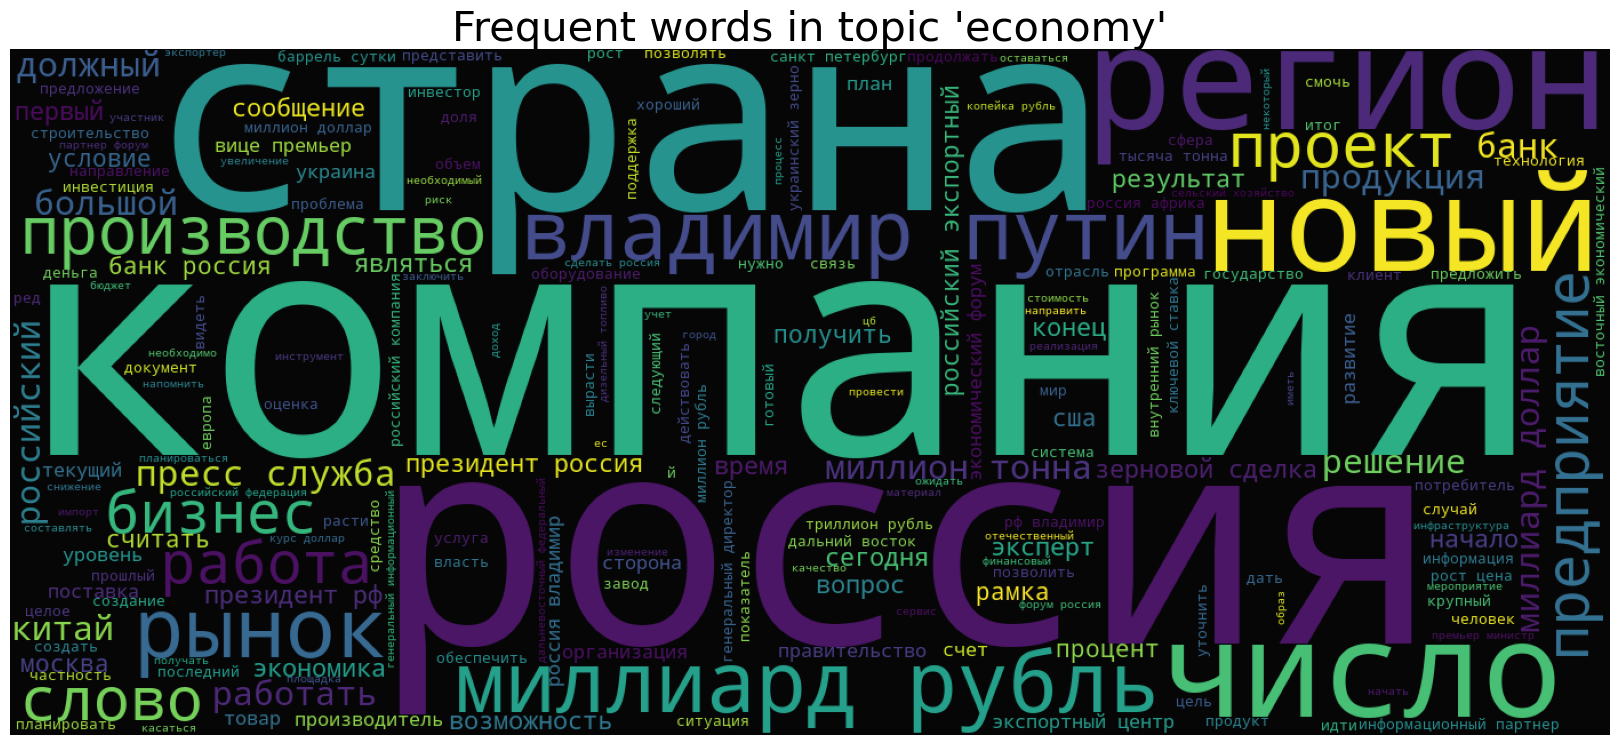

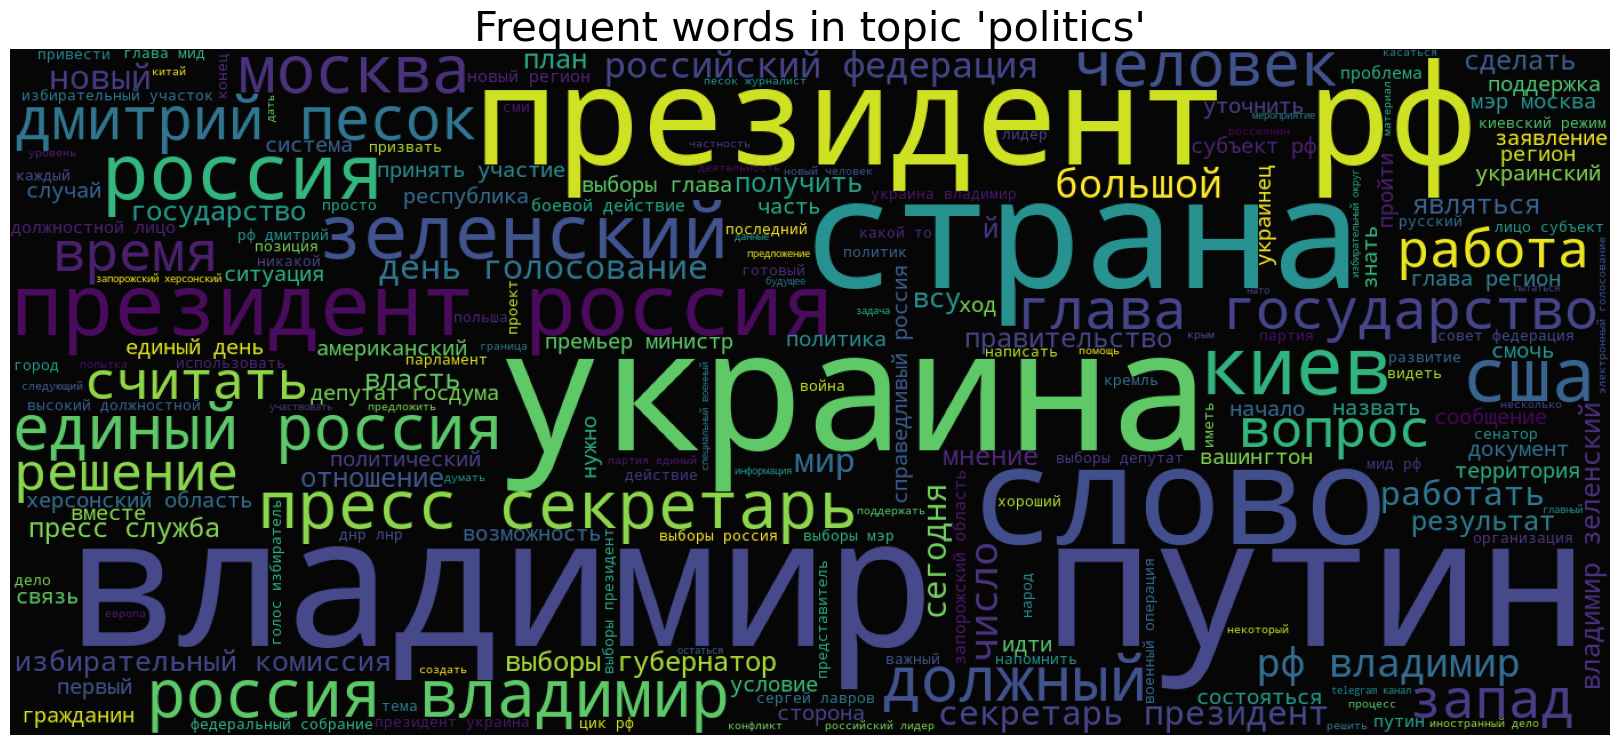

In [ ]:
for topic in preprocessed_train.topic.unique():
    words = preprocessed_train[preprocessed_train.topic == topic].lemmas.str.split(' ').explode().values

    wc = WordCloud(background_color="black", width=1400, height=600)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in topic '{topic}'", fontsize=30)
    ax.imshow(wc, alpha=0.98)

We can see mistakes of lemmatization such as 'газ' in 'сектор Газа', 'песок' in 'Дмитрий Песок'. These words become homonymous with ordinary words like 'газ (природный)' and 'песок' (вещество).

We also see that topics such as religion, incidents, culture are well distinguishable and There are intersections in the topics of world, economy, society, defense safety and politics. But it is quite natural, these topics can actually overlap and be hard to distinguish.

## Text Statistics

In [13]:
tokens_train = preprocessed_train.text_clean.apply(text_helper.tokenize)
tokens_test = preprocessed_test.text_clean.apply(text_helper.tokenize)

def flatten(tokenized_texts):
    return [word for text in tokenized_texts for word in text]

tokens_train = flatten(tokens_train)
tokens_test = flatten(tokens_test)
lemmas_train = flatten(preprocessed_train.lemmas.str.split())
lemmas_test = flatten(preprocessed_test.lemmas.str.split())

data = {
    'Train': {
        'Number of docs in the corpus': len(preprocessed_train),
        'Number of tokens': len(tokens_train),
        'Size of vocabulary': len(set(tokens_train)),
        'Number of lemmas': len(lemmas_train),
        'Size of lemmatized vocabulary': len(set(lemmas_train)),
    },

    'Test': {
        'Number of docs in the corpus': len(preprocessed_test),
        'Number of tokens': len(tokens_test),
        'Size of vocabulary': len(set(tokens_test)),
        'Number of lemmas': len(lemmas_test),
        'Size of lemmatized vocabulary': len(set(lemmas_test)),
    },
}

# Create DataFrame from the data
info_text_df = pd.DataFrame(data)
info_text_df

Train     Test
Number of docs in the corpus     33768     8442
Number of tokens               7762439  1915384
Size of vocabulary              273386   138162
Number of lemmas               5255431  1296314
Size of lemmatized vocabulary   112078    57404

In [14]:
print("Most 50 Common Lemmas:\n", Counter(lemmas_train).most_common(50))
print("Most 50 Rare Lemmas:\n", Counter(lemmas_train).most_common()[:-51:-1])

Most 50 Common Lemmas:
 [('россия', 37990), ('человек', 22134), ('российский', 20686), ('страна', 17067), ('рф', 16769), ('новый', 16610), ('украина', 16253), ('область', 14468), ('день', 14244), ('президент', 13942), ('время', 13935), ('военный', 13586), ('украинский', 13184), ('слово', 13149), ('тысяча', 12656), ('первый', 12338), ('глава', 11636), ('путин', 11154), ('работа', 11140), ('число', 10863), ('регион', 10653), ('москва', 10038), ('израиль', 9870), ('газ', 9463), ('церковь', 9412), ('район', 9052), ('владимир', 9010), ('1-й', 8588), ('данные', 8451), ('получить', 8393), ('ученый', 8325), ('решение', 8294), ('проект', 8240), ('сектор', 8236), ('сторона', 8131), ('вопрос', 8122), ('дело', 7997), ('система', 7974), ('большой', 7874), ('сообщение', 7828), ('сша', 7788), ('территория', 7761), ('рубль', 7663), ('город', 7573), ('центр', 7460), ('результат', 7456), ('власть', 7426), ('часть', 7057), ('компания', 7006), ('место', 6995)]
Most 50 Rare Lemmas:
 [('шевцовой', 1), ('пен

##  Functions

In [15]:
def predict_evaluate(X_test, y_test, model, model_name, vectorizer_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    predicting_time = time.time() - start_time
    f1score = round(f1_score(y_test, y_pred, average='macro'), 3)

    result_df = pd.DataFrame({
        'model': [model_name],
        'vectorizer': [vectorizer_name],
        'f1': [f1score],
        'predicting time': [predicting_time]
    })

    print(f'F1 Score Macro Average: {f1score}')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(data=cm_percentage, columns=np.unique(y_test), index=np.unique(y_pred))

    plt.figure(figsize=(12, 4))
    sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='.2f', cbar=False)
    plt.xlabel('\nPredicted Label', fontsize=16)
    plt.ylabel('True Label\n', fontsize=16)
    plt.title(f'Confusion Matrix - {model_name} (Percentage)\n', fontsize=18)
    plt.show()

    return result_df, y_pred

Dataframe for keeping results

In [16]:
summary = pd.DataFrame(columns=['model', 'vectorizer', 'f1', 'predicting time'])

In [17]:
#features
X_train = preprocessed_train.lemmas
X_test = preprocessed_test.lemmas
#targets
y_train = preprocessed_train.topic.values
y_test = preprocessed_test.topic.values

## Tf-idf

In [19]:
params = {'penalty': ['l2'],
          'solver': ['lbfgs','newton-cg', 'saga'],
          'C' : np.arange(0.01, 2.01, 0.25)}

tfidf = TfidfVectorizer(max_features=15000,
                        analyzer="word",
                        ngram_range=(1, 2))

tfidf.fit(X_train, y_train)
X_train_tfidf = tfidf.transform(X_train)

gs = GridSearchCV(LogisticRegression(random_state=42, max_iter=10000), params, cv=10, scoring='f1_macro', n_jobs=-1)
gs.fit(X_train_tfidf, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.8769261088637709
{'C': 1.76, 'penalty': 'l2', 'solver': 'saga'}


F1 Score Macro Average: 0.881
                precision    recall  f1-score   support

       culture       0.94      0.93      0.94       941
defense_safety       0.86      0.86      0.86       960
       economy       0.88      0.93      0.91       941
     incidents       0.86      0.93      0.90       946
      politics       0.83      0.81      0.82       993
      religion       0.97      0.93      0.95       917
       science       0.94      0.96      0.95       894
       society       0.78      0.77      0.78       896
         world       0.86      0.79      0.83       954

      accuracy                           0.88      8442
     macro avg       0.88      0.88      0.88      8442
  weighted avg       0.88      0.88      0.88      8442



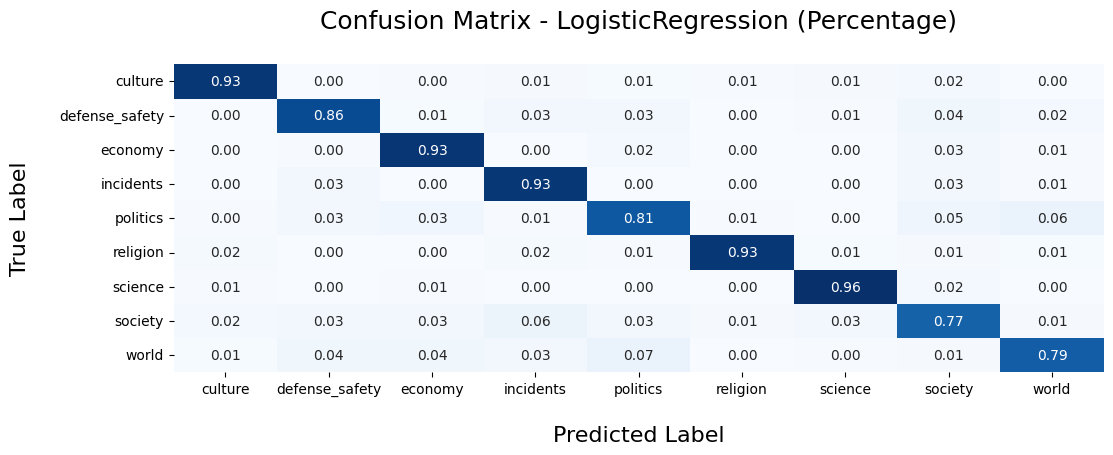

CPU times: user 37.6 s, sys: 1.46 s, total: 39.1 s
Wall time: 38 s


model vectorizer     f1  predicting time
0  LogisticRegression      Tfidf  0.881         2.648436

In [20]:
%%time
pipe = Pipeline([('tfidf', TfidfVectorizer(max_features=15000,
                                           analyzer="word",
                                           #stop_words=mystopwords,
                                           ngram_range=(1, 2))),
                 ('clf', LogisticRegression(C=1.76, penalty='l2', solver='saga',random_state=42,
                                            max_iter=10000, n_jobs=-1))])

pipe.fit(X_train, y_train)

result_df, tfidf_preds = predict_evaluate(X_test, y_test, pipe, 'LogisticRegression', 'Tfidf')
summary = pd.concat([summary, result_df], ignore_index=True)
summary

We got a good result with tfidf Vectorizer  - 0.881.

The model best classify the topics  'culture', 'economy','incidents', 'religion', 'science'. The model makes more mistakes while classifying the topics 'society', 'world', 'politcs' and 'defense safety'. And it is quite natural because these topics can naturally overlap in news.


Below we display the weights (coefficients) of the features produced by the LogisticRegression classifier ('clf') within the pipeline.
The features correspond to the terms extracted by the TfidfVectorizer ('tfidf').

In [21]:
eli5.show_weights(estimator=pipe.named_steps['clf'],
                  vec = pipe.named_steps['tfidf'],
                  feature_names=pipe.named_steps['tfidf'].get_feature_names_out(),
                  target_names=preprocessed_test.topic,
                  top=(10, 10))

In the whole our classifier assigns high weights to related words in each topic.

## Save the model

In [22]:
with open('/content/gdrive/MyDrive/Colab_Notebooks/News_Analytics_Project/logreg/logreg_tfidf.pkl', 'wb') as file:
    pickle.dump(pipe, file)

In [ ]:
#with open('logreg_tfidf.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)

## Logistic Regression with Word2vec embeddings

For vectorizing words in our documents we will use *embeddings*, short dense vectors.

Representing words as 400-dimensional dense vectors requires our classifiers
to learn far fewer weights, and the smaller parameter space possibly helps with generalization and avoiding overfitting. Dense vectors may also do a better job of capturing synonymy.
I will apply word2vec algorithm (Mikolov et al. 2013a, Mikolov et al.
2013b) using Gensim library.

Let's see what is the minimum length of our sentence to help to choose the window size for Word2Vec.

In [23]:
preprocessed_train['lemmas'].apply(lambda x: len(x.split())).min()

7

We will set the window size based on the minimum sentence length in our corpus.
We choose the skip-gram algorithm and enable negative sampling (to prevent overfitting).
We will set the threshold for rare words to 15. The vector dimension will be 400. These parameters have been selected through several experiments.

The input of Gensim Word2Vec should be iterable, in our case every document will be a number of lemmas it contains.

In [24]:
#features
X_train = preprocessed_train.lemmas.str.split()
X_test = preprocessed_test.lemmas.str.split()

In [25]:
%%time
word2vec = Word2Vec(sentences=X_train,
                 vector_size=400,
                 min_count=15,
                 window=7,
                sg=1,
                negative=5,
                workers=4,
                seed=42
                   )

CPU times: user 9min 6s, sys: 3.5 ms, total: 9min 6s
Wall time: 2min 18s


In [26]:
word2vec.wv.most_similar(positive=["путин"],topn=10)

[('президент', 0.6249653100967407),
 ('владимир', 0.6225631833076477),
 ('садыр', 0.5677522420883179),
 ('теббуна', 0.5655583739280701),
 ('касым-жомартом', 0.5618468523025513),
 ('рахмон', 0.5580183863639832),
 ('абдельмаджид', 0.5430778861045837),
 ('токаев', 0.5421146750450134),
 ('жапар', 0.5412542223930359),
 ('эмомали', 0.5345441699028015)]

In [27]:
word2vec.wv.most_similar(positive=["нефть"])

[('баррель', 0.6799920201301575),
 ('brent', 0.6284241080284119),
 ('urals', 0.625267744064331),
 ('нефтяной', 0.6000033020973206),
 ('добыча', 0.5893986821174622),
 ('нефтепродукт', 0.5844089984893799),
 ('трубопроводный', 0.5719871520996094),
 ('энергоноситель', 0.5676632523536682),
 ('мэа', 0.5637897849082947),
 ('опек', 0.5624178647994995)]

In [28]:
word2vec.wv.most_similar(positive=["происшествие"])

[('следственно-оперативный', 0.6570559740066528),
 ('криминалист', 0.62392258644104),
 ('травмирование', 0.6102002263069153),
 ('peugeot', 0.6018475294113159),
 ('оперативно-розыскной', 0.5881708264350891),
 ('доследственный', 0.5781981348991394),
 ('ваз-1', 0.5757530927658081),
 ('госавтоинспекция', 0.5756987929344177),
 ('угибдд', 0.5754345059394836),
 ('выясняться', 0.574327290058136)]

In [29]:
word2vec.wv.most_similar(positive=["вакцина"])

[('ковивак', 0.7347850203514099),
 ('эпиваккорона', 0.722632646560669),
 ('ревакцинация', 0.6951753497123718),
 ('векторный', 0.6909827589988708),
 ('мрнк-вакцина', 0.6859078407287598),
 ('astrazeneca', 0.6791037321090698),
 ('moderna', 0.6757303476333618),
 ('полиомиелит', 0.6749410033226013),
 ('аденовирус', 0.6694624423980713),
 ('гамалея', 0.6544949412345886)]

In [30]:
word2vec.wv.most_similar(positive=["лук"])

[('чеснок', 0.7955127954483032),
 ('морковь', 0.7914385199546814),
 ('огурец', 0.7694146633148193),
 ('помидор', 0.7618193030357361),
 ('свекла', 0.7609941363334656),
 ('сливочный', 0.7411217093467712),
 ('капуста', 0.7393328547477722),
 ('злак', 0.7385285496711731),
 ('фруктовый', 0.7327377200126648),
 ('тушеный', 0.7295846343040466)]

There are various ways to represent an input for classification. One simple baseline
is to apply some sort of pooling function to the embeddings of all the words in the pooling
input. For example, for a text with n input words/tokens w<sub>i</sub>...,w<sub>n</sub>, we can turn the n embeddings e(w<sub>i</sub>) ...,e(w<sub>n</sub>) (each of dimensionality d) into a single embedding also of dimensionality d by just summing the embeddings, or by taking their mean
(summing and then dividing by n). Here we take the mean:

In [31]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model, embedding_model_name):
        self.embedding_model_name = embedding_model_name
        self.embedding_model = model.wv
        self.dim = model.vector_size
    def fit(self, X, y):
        return self

    def transform(self, X):

        return np.array([
            np.mean([self.embedding_model.get_vector(w)
                for w in words if w in self.embedding_model] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

F1 Score Macro Average: 0.859
                precision    recall  f1-score   support

       culture       0.92      0.93      0.92       941
defense_safety       0.83      0.82      0.82       960
       economy       0.88      0.94      0.91       941
     incidents       0.87      0.90      0.89       946
      politics       0.78      0.76      0.77       993
      religion       0.96      0.94      0.95       917
       science       0.92      0.95      0.93       894
       society       0.77      0.75      0.76       896
         world       0.81      0.76      0.78       954

      accuracy                           0.86      8442
     macro avg       0.86      0.86      0.86      8442
  weighted avg       0.86      0.86      0.86      8442



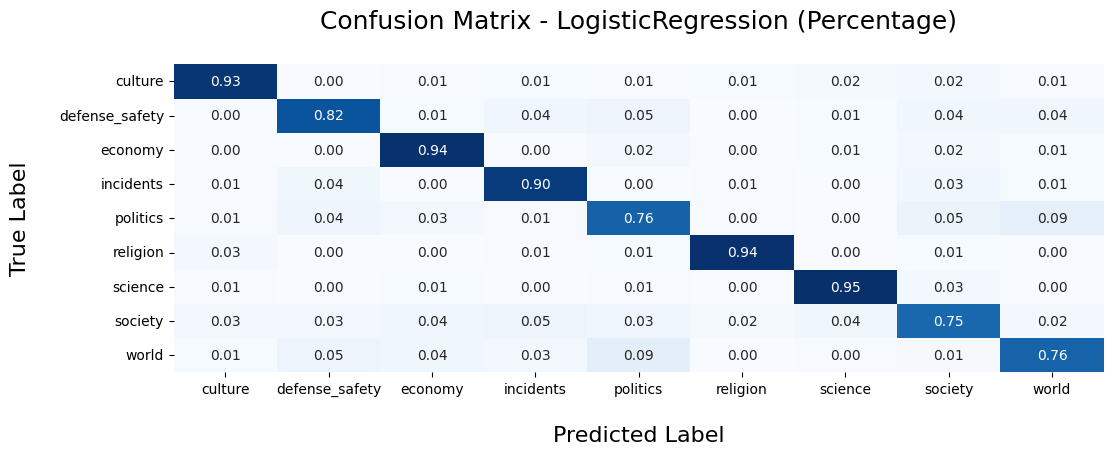

CPU times: user 20.2 s, sys: 2.42 s, total: 22.6 s
Wall time: 47.7 s


model                  vectorizer     f1  predicting time
0  LogisticRegression                       Tfidf  0.881         2.648436
1  LogisticRegression  Word2Vec with Mean Pooling  0.859         3.920810

In [32]:
%%time
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(word2vec, 'Word2Vec with Mean Pooling')),
                 ('clf', LogisticRegression(random_state=42,
                                            max_iter=10000, n_jobs=-1))])


pipe.fit(X_train, y_train)

result_df, w2v_preds = predict_evaluate(X_test, y_test, pipe, 'LogisticRegression', 'Word2Vec with Mean Pooling')
summary = pd.concat([summary, result_df], ignore_index=True)
summary

In [33]:
summary.to_csv(os.path.join(data_path,'summary_ml.csv'), index=False)

We trained word2vec on our corpus and got worse results than with tf-idf vectorizer.
Let us check the number of out of vocabulary words in test set.

In [34]:
oov_words = set([word for sequence in X_test for word in sequence if word not in word2vec.wv])
len(oov_words)

37382

We have quite a big portion of OOV words. For experimenting further with these embeddings, we should try pretrained models, for example GloVe embeddings from navec library trained on news texts: navec_news_v1_1B_250K_300d_100q.tar.